In [1]:
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')
drive.mount('/drive')

Mounted at /content/drive
Mounted at /drive


# **Data Exploration**

In [3]:
# Dataset 1 (hatespeech)
data1 = pd.read_csv("/drive/MyDrive/Colab Notebooks/dataset_hatespeech.csv")

# Dataset 2 (sexism)
data2 = pd.read_csv("/drive/MyDrive/Colab Notebooks/dataset_sexism.csv")

In [15]:
print(data1.info())
print("\nNull Value : \n",data1.isnull().sum())
print("\nMean : \n",data1.mean())
print("\nMode : \n",data1.mode())
print("\nStandard Deviation : \n", data1.std(skipna = True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB
None

Null Value : 
 Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

Mean : 
 Unnamed: 0            12681.192027
count                     3.243473
hate_speech               0.280515
offensive_language        2.413711
neither                   0.549247
class                  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


In [16]:
print(data2.info())
print("\nNull Value : \n",data2.isnull().sum())
print("\nMean : \n",data2.mean())
print("\nMode : \n",data2.mode())
print("\nStandard Deviation : \n", data2.std(skipna = True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14881 entries, 0 to 14880
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       14881 non-null  object 
 1   id          14880 non-null  object 
 2   Text        14880 non-null  object 
 3   Annotation  14878 non-null  object 
 4   oh_label    14878 non-null  float64
dtypes: float64(1), object(4)
memory usage: 581.4+ KB
None

Null Value : 
 index         0
id            1
Text          1
Annotation    3
oh_label      3
dtype: int64

Mean : 
 oh_label    0.226979
dtype: float64

Mode : 
                                index                     id  \
0                        #yesallmen   3.19399851215434E+017   
1              3.19399851215434E+017  3.20817818222358E+017   
2              3.20817818222358E+017  3.24114200450437E+017   
3              3.24114200450437E+017  3.26286656854454E+017   
4              3.26286656854454E+017  3.81988216292655E+017   
...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


# **Data Preprocessing**

Missing Value


In [17]:
# Dropping rows that has null values
data2.dropna(inplace=True)

Data Transformation

In [20]:
# Dataset 1 (hatespeech)
# Rename Column
data1.rename(columns={'class': 'Sentiment', 'tweet': 'Tweet'}, inplace=True)

# Selecting the important column
data1 = data1[['Tweet', 'Sentiment']]

# Replacing values to True or False
data1['Sentiment'] = data1['Sentiment'].replace(0, 1).replace(2, 0)

In [21]:
# Dataset 2 (sexism)
# Rename columns 
data2.rename(columns={'oh_label': 'Sentiment'}, inplace=True)
data2.rename(columns={'Text': 'Tweet'}, inplace=True)

# Selecting the important column
data2 = data2[['Tweet', 'Sentiment']]

# Change the data type
data2['Sentiment'] = data2['Sentiment'].astype(int)

In [22]:
# Combining the 2 datasets
df = pd.concat([data1, data2], ignore_index=True)

Text Preprocessing

In [23]:
def preprocessing(text):
    stopW = stopwords.words('english')

    # Remove negation words in the stopword list
    stopWRemove = []
    for i in stopW:
        x = re.findall(r'[\']t$|not?', i)
        if x:
            stopWRemove.append(i)

    for i in stopWRemove:
        if i in stopW:
            stopW.remove(i)

    lemma = WordNetLemmatizer()

    text = re.sub(r'RT[\s]', ' ', text) # remove RT keyword
    text = re.sub(r'@[a-zA-Z0-9_]+', ' ', text) # remove username
    text = re.sub(r'https?://[a-zA-Z0-9/.]+', ' ', text) # remove URL
    text = re.sub(r'[^\w\s]', ' ', text) # remove punctuation
    text = re.sub(r'\d+', ' ', text) # remove digits
    text = text.lower() # convert text to lower case
    text = text.split() # tokenize the word
    text = [lemma.lemmatize(t) for t in text] # lemmatize the word
    text = [word for word in text if word not in stopW] # remove stopwords
    return text


# Create a new column for the cleaned text
prep_text = df.apply(lambda x: preprocessing(x['Tweet']), axis=1)

combinedText = []
def listToString(list):
    for i in list:
        i = ' '.join(map(str, i))
        combinedText.append(i)

listToString(prep_text.values)
df['CleanedTweet'] = combinedText

df

,Tweet,Sentiment,CleanedTweet
0,!!! RT @mayasolovely: As a woman you shouldn't...,1,woman complain cleaning house amp man always t...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1,boy dat cold tyga dwn bad cuffin dat hoe st place
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1,dawg ever fuck bitch start cry confused shit
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1,look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1,shit hear might true might faker bitch told ya
...,...,...,...
39656,@RaikonL @finaleve @mja333 WHY DO YOU HATE FRE...,0,hate freedom
39657,It is unconscionable that our regulatory bodie...,0,unconscionable regulatory body transparently b...
39658,@Dartanveerahmad @Janx53 @geehall1 We want ISI...,0,want isi remain perfect killing place send rei...
39659,#mkr Unbelievable how low Kat &amp; Andre wil...,0,mkr unbelievable low kat amp andre go despicab...


# **Data Visualization**

Pie Chart

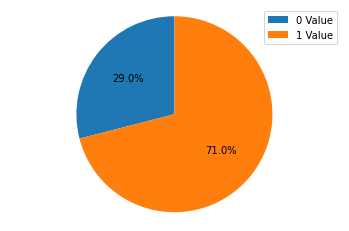

In [24]:
# Count number of 0 (Positive)
test0 = df.apply(lambda x : True
            if x['Sentiment'] == 0 else False, axis = 1)
num_0 = len(test0[test0 == True].index)

# Count number of 1 (Negative)
test1 = df.apply(lambda x : True
            if x['Sentiment'] == 1 else False, axis = 1)
num_1 = len(test1[test1 == True].index)

# Generate Pie Chart
labels = ['0 Value', '1 Value']
sizes = [num_0, num_1]
pie = plt.pie(sizes,autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.legend(labels, loc="best")
plt.show()

Word Cloud - Sentiment Value 1

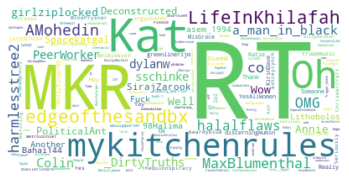

In [26]:
#Creating the text variable for Sentiment Value 0 
corpus_0 = df.loc[df['Sentiment'] == 0, "Tweet"]
text = " ".join(cat.split()[0] for cat in corpus_0)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud - Sentiment Value 1

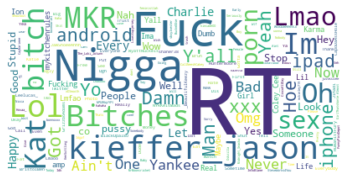

In [ ]:
#Creating the text variable for Sentiment Value 1
corpus_1 = df.loc[df['Sentiment'] == 1, "Tweet"]
text = " ".join(cat.split()[0] for cat in corpus_1)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Model Training**

Select independent and target variable

In [27]:
# Select independent and target variable
x_class = df['CleanedTweet'].values
y_class = df['Sentiment'].values

Train Test Split

In [28]:
# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(x_class, y_class, test_size=0.2, random_state=42)

Feature scaling

In [29]:
# Feature extraction using TF-IDF
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

Solve class imbalance

In [30]:
# Oversampling using ADASYN
ada = ADASYN(random_state=42)
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

**Multinomial Naive Bayes**

In [31]:
# Instantiate the Machine Learning Model (Naive Bayes)
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_ada, y_train_ada)
y_predict_nb = naive_bayes_classifier.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_predict_nb)

**Linear SVM Model**

In [32]:
# Instantiate the Machine Learning Model (Support Vector Machines)
svm = LinearSVC(random_state=42)
svm.fit(X_train_ada, y_train_ada)
y_predict_svm = svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_predict_svm)

# **Report**

In [33]:
print("\n------REPORT------")
print("\nMachine Learning Model (Naive Bayes)\n\nAccuracy: ", accuracy_nb)
print("\nClassification Report:\n\n", metrics.classification_report(y_test, y_predict_nb))
print("\n-------------------------------------------------------")
print("\nMachine Learning Model (Support Vector Machines)\n\nAccuracy: ", accuracy_svm)
print("\nClassification Report:\n\n", metrics.classification_report(y_test, y_predict_svm))


------REPORT------

Machine Learning Model (Naive Bayes)

Accuracy:  0.8978948695323333

Classification Report:

               precision    recall  f1-score   support

           0       0.82      0.84      0.83      2320
           1       0.93      0.92      0.93      5613

    accuracy                           0.90      7933
   macro avg       0.88      0.88      0.88      7933
weighted avg       0.90      0.90      0.90      7933


-------------------------------------------------------

Machine Learning Model (Support Vector Machines)

Accuracy:  0.9396193117357872

Classification Report:

               precision    recall  f1-score   support

           0       0.87      0.94      0.90      2320
           1       0.97      0.94      0.96      5613

    accuracy                           0.94      7933
   macro avg       0.92      0.94      0.93      7933
weighted avg       0.94      0.94      0.94      7933

